# Arrival time prediction for the next bus stop
## Group 2: Jesper & Nutta
## AH2179 - Applied AI in Transportation

## This work file is for the models without weather data

In [1]:
!pip install calplot pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for calplot: filename=calplot-0.1.7.5-py3-none-any.whl size=8115 sha256=43dbc25e02d09450e648998eca04111bf4de09b269e9815d140b38af78691331
  Stored in directory: /root/.cache/pip/wheels/77/75/32/a518a4a1421776a93e1ede33cb8dac474095bf31fed7e4e22c
Successfully built calplot


In [2]:
import pandas as pd

#Plot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import calendar
import calplot # actually used

# Score model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

## Load and Interpret Data

In [3]:
url = "https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/main/ProjectAssignmentData/Dataset-PT.csv"
df = pd.read_csv(url,header=1)

In [4]:
df.head(5)
# df.size 545104 rows

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(weather)Rain,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,0,0,0,1,0,1,0,0,1
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,0,0,0,1,0,1,0,0,1
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,0,0,0,1,0,1,0,0,1
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,0,0,0,1,0,1,0,0,1
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,0,0,0,1,0,1,0,0,1


In [5]:
df.shape

(545103, 31)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545103 entries, 0 to 545102
Data columns (total 31 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Calendar_date                      545103 non-null  int64  
 1   route_id                           545103 non-null  int64  
 2   bus_id                             545103 non-null  int64  
 3   stop_sequence                      545103 non-null  int64  
 4   arrival_delay                      545103 non-null  int64  
 5   dwell_time                         545103 non-null  int64  
 6   travel_time_for_previous_section   545103 non-null  int64  
 7   scheduled_travel_time              545103 non-null  int64  
 8   upstream_stop_delay                545103 non-null  int64  
 9   origin_delay                       545103 non-null  int64  
 10  previous_bus_delay                 545103 non-null  int64  
 11  previous_trip_travel_time          5451

**Which bus stop has the highest delay?**

In [7]:
max_delay_row = df[df['arrival_delay'] == df['arrival_delay'].max()]
print(max_delay_row)

        Calendar_date  route_id  bus_id  stop_sequence  arrival_delay  \
490068       20220609         4   44063             19           2257   

        dwell_time  travel_time_for_previous_section  scheduled_travel_time  \
490068          26                                41                     57   

        upstream_stop_delay  origin_delay  ...  factor(weather)Rain  \
490068                 2231          1285  ...                    0   

        factor(weather)Snow  factor(temperature)Cold  \
490068                    0                        0   

        factor(temperature)Extra_cold factor(temperature)Normal  \
490068                              0                         1   

       factor(day_of_week)weekday factor(day_of_week)weekend  \
490068                          1                          0   

       factor(time_of_day)Afternoon_peak  factor(time_of_day)Morning_peak  \
490068                                 0                                0   

        factor(time

In [8]:
# Group the DataFrame by 'stop_sequence' and calculate the mean delay for each group
mean_delay_by_stop = df.groupby('stop_sequence')['arrival_delay'].mean()

# Find the 'stop_sequence' with the maximum mean delay
max_mean_delay_stop_sequence = mean_delay_by_stop.idxmax()

# Print the 'stop_sequence' with the maximum mean delay
print("Stop Sequence with Maximum Mean Delay:", max_mean_delay_stop_sequence)

Stop Sequence with Maximum Mean Delay: 19


In [9]:
count_19 = (df['stop_sequence'] == 19).sum()
print("Number of rows with 'stop_sequence' equal to 19:", count_19)

Number of rows with 'stop_sequence' equal to 19: 20189


In [10]:
# Use the nunique() function to count the number of unique values in the column
unique_count = df['bus_id'].nunique()

# Print the result
print(f"Number of different numbers in the column: {unique_count}")

Number of different numbers in the column: 152


In [11]:
# Use the nunique() function to count the number of unique values in the column
unique_count = df['stop_sequence'].nunique()

# Print the result
print(f"Number of different numbers in the column: {unique_count}")

Number of different numbers in the column: 27


In [12]:
# The average waiting time based on the given frequency should be Headway/2 ( 6/2 = 3 minutes)
# The Waiting Time Paradox: if a bus arrives on average every 6 minutes, the average waiting time will be 6 minutes.

# Simulating Wait Times

import numpy as np
N = df['bus_id'].nunique()  # number of buses
tau = 6 # using the maximum of 4-6 minutes/departure

rand = np.random.RandomState(42)  # universal random seed
bus_arrival_times = N * tau * np.sort(rand.rand(N))

intervals = np.diff(bus_arrival_times)
intervals.mean()

5.927183545449976

<ipython-input-13-dd6ad2bb817b>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


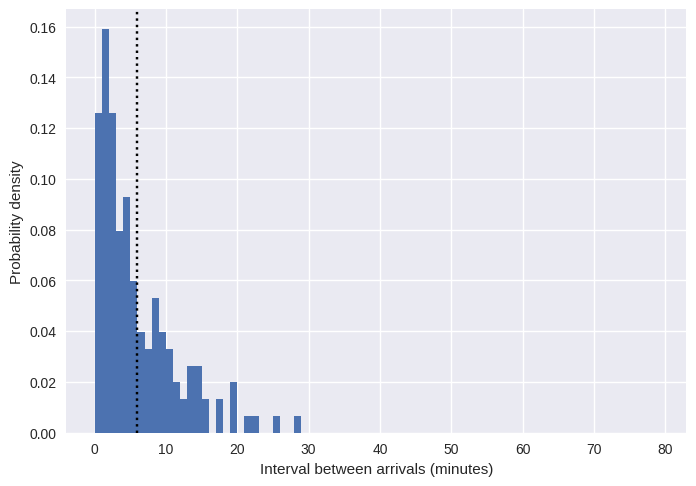

In [13]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

plt.hist(intervals, bins=np.arange(80), density=True)
plt.axvline(intervals.mean(), color='black', linestyle='dotted')
plt.xlabel('Interval between arrivals (minutes)')
plt.ylabel('Probability density');

In [14]:
#from scipy.stats import poisson

# count the number of arrivals in 1-hour bins
#binsize = 60
#binned_arrivals = np.bincount((bus_arrival_times // binsize).astype(int))
#x = np.arange(20)

# plot the results
#plt.hist(binned_arrivals, bins=x - 0.5, density=True, alpha=0.5, label='simulation')
#plt.plot(x, poisson(binsize / tau).pmf(x), 'ok', label='Poisson prediction')
#plt.xlabel('Number of arrivals per hour')
#plt.ylabel('frequency')
#plt.legend();

In [15]:
#import seaborn as sns
#import matplotlib.pyplot as plt

# Create a FacetGrid with 4 columns (4 graphs in a row)
#g = sns.FacetGrid(df, col="stop_sequence", col_wrap=3)
#g.map(sns.histplot, "arrival_delay", bins=np.arange(-500, 500))
#g.set_titles('{col_name}')
#g.set_axis_labels('arrival delay', 'number of buses')


#plt.tight_layout()
#plt.show()

In [16]:
df = df.drop(['Calendar_date','route_id', 'bus_id'], axis = 1)
columns_to_drop = [
    'weather', 'temperature',
    'factor(weather)Light_Rain', 'factor(weather)Light_Snow',
    'factor(weather)Normal', 'factor(weather)Rain', 'factor(weather)Snow',
    'factor(temperature)Cold', 'factor(temperature)Extra_cold',
    'factor(temperature)Normal', 'factor(day_of_week)weekday',
    'factor(day_of_week)weekend', 'factor(time_of_day)Afternoon_peak',
    'factor(time_of_day)Morning_peak', 'factor(time_of_day)Off-peak'
]
for column in columns_to_drop:
    df.pop(column)

<ipython-input-17-d36092b55db5>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()
<ipython-input-17-d36092b55db5>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


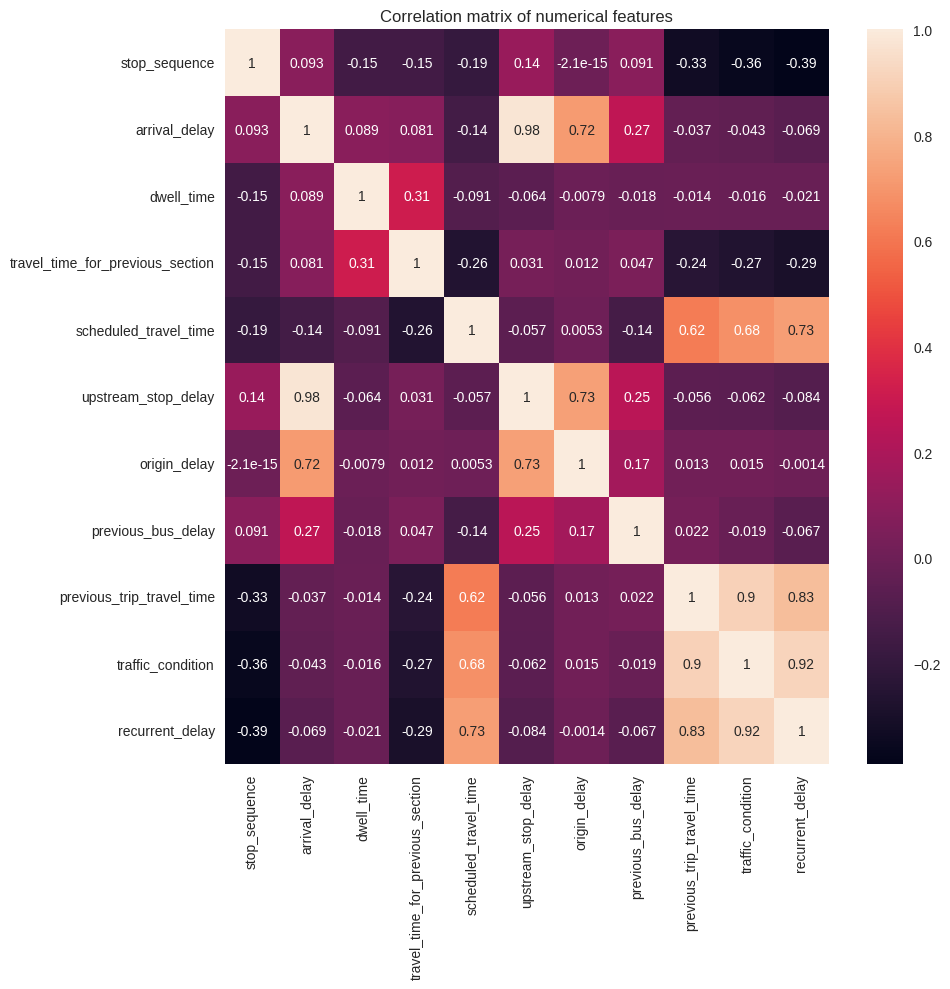

In [17]:
corr_matrix = df.corr()
corr_matrix['arrival_delay'].sort_values(ascending=False)
plt.subplots(figsize=(10,10))
corr = df.corr()
sns.heatmap(corr, annot = True)
plt.title("Correlation matrix of numerical features")
plt.tight_layout()
plt.show()

From the above correlation matrix, it looks like the strongest variables that influence arrival_delay are:\
upstream_stop_delay and origin_delay.\
recurrent_delay has a strong influence with traffic_condition, previous_trip_travel_time and schedule_travel_time.

In [18]:
# Extract only 'Weekdays' from day_of_week to train
# Filter the data
df_weekday = df[df['day_of_week'] == 'weekday']
df_weekend = df[df['day_of_week'] == 'weekend']

print(df_weekday.shape)
print(df_weekend.shape)

(418149, 13)
(126954, 13)


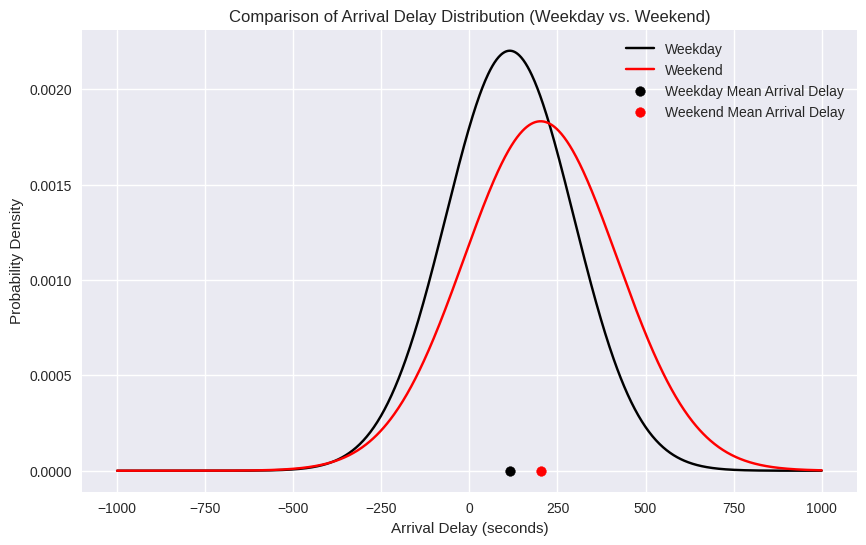

In [19]:
from scipy.stats import norm

# Check the distributions of weekday and weekend delays

# Extract 'arrival_delay' data for both datasets
arrival_delay_weekday = df_weekday['arrival_delay']
arrival_delay_weekend = df_weekend['arrival_delay']

# Calculate mean and standard deviation for each dataset
mean_weekday = arrival_delay_weekday.mean()
std_dev_weekday = arrival_delay_weekday.std()
mean_weekend = arrival_delay_weekend.mean()
std_dev_weekend = arrival_delay_weekend.std()

# Generate x values for the probability density functions (PDFs)
x = np.linspace(-1000, 1000, 1000)

# Calculate PDFs for the normal distributions
pdf_weekday = norm.pdf(x, loc=mean_weekday, scale=std_dev_weekday)
pdf_weekend = norm.pdf(x, loc=mean_weekend, scale=std_dev_weekend)

# Create a plot
plt.figure(figsize=(10, 6))

# Plot the PDFs for both datasets
plt.plot(x, pdf_weekday, label='Weekday', color='black')
plt.plot(x, pdf_weekend, label='Weekend', color='red')

# Add dots for the mean arrival delays
plt.scatter([mean_weekday], [0], color=['black'], marker='o', label='Weekday Mean Arrival Delay')
plt.scatter([mean_weekend], [0], color=['red'], marker='o', label='Weekend Mean Arrival Delay')

plt.xlabel('Arrival Delay (seconds)')
plt.ylabel('Probability Density')
plt.title('Comparison of Arrival Delay Distribution (Weekday vs. Weekend)')
plt.legend()
plt.grid(True)

#plt.grid(False)
plt.show()

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545103 entries, 0 to 545102
Data columns (total 13 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   stop_sequence                     545103 non-null  int64  
 1   arrival_delay                     545103 non-null  int64  
 2   dwell_time                        545103 non-null  int64  
 3   travel_time_for_previous_section  545103 non-null  int64  
 4   scheduled_travel_time             545103 non-null  int64  
 5   upstream_stop_delay               545103 non-null  int64  
 6   origin_delay                      545103 non-null  int64  
 7   previous_bus_delay                545103 non-null  int64  
 8   previous_trip_travel_time         545103 non-null  int64  
 9   traffic_condition                 545103 non-null  float64
 10  recurrent_delay                   545103 non-null  float64
 11  day_of_week                       545103 non-null  o

## Base Line Model (Regression)

#### Training and Prediction

In [21]:
from sklearn.model_selection import cross_val_score

# Create a copy of the subset
subset = df_weekday[['traffic_condition', 'recurrent_delay']].copy()

# Convert 'traffic_condition' and 'recurrent_delay' columns to int in the copy
subset['traffic_condition'] = subset['traffic_condition'].astype(int)
subset['recurrent_delay'] = subset['recurrent_delay'].astype(int)

# Update the original DataFrame with the modified copy
df_weekday[['traffic_condition', 'recurrent_delay']] = subset

# Define Independent and dependent variables
x = df_weekday.drop(['arrival_delay', 'day_of_week', 'time_of_day' ], axis=1)
y = df_weekday['arrival_delay']

# Miltiple Linear Regression Model
model_1R = LinearRegression()
# Try corss validation score first
cross_val_score(model_1R, x, y, cv=5).mean()

<ipython-input-21-8c7100f61bd4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekday[['traffic_condition', 'recurrent_delay']] = subset


0.9856262127427954

#### Visualize the results

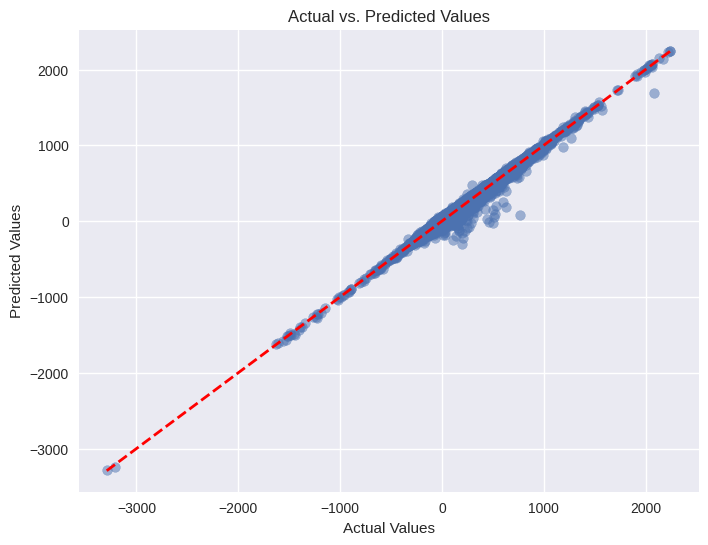

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Fit the model to the training data
model_1R.fit(x_train, y_train)

y_pred = model_1R.predict(x_test)

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

#### Evaluate the Base Line Model

In [23]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 13.088761400032576
Mean Squared Error: 398.23486973014826
R-squared: 0.9878742408890404


## Prepare the data

The dataset contains 545104 rows and 12 columns.\
I decided to select a bus stop to predict arrival time.
Stop 19 was selected because it has the highest mean delay value.

In [24]:
desired_stop_sequence = 19  # Replace with your specific stop sequence number

# Create a boolean mask for rows with the desired stop sequence
mask = df['stop_sequence'] == desired_stop_sequence

# Filter the DataFrame to keep only the rows with the desired stop sequence
df_stop19 = df[mask]

df_stop19.shape

(20189, 13)

In [25]:
# Filter the data
# Extract 'weekday' and 'weekend' from day_of_week to train
df_stop19_weekday = df_stop19[df_stop19['day_of_week'] == 'weekday']
df_stop19_weekend = df_stop19[df_stop19['day_of_week'] == 'weekend']
print(df_stop19_weekday.shape)
print(df_stop19_weekend.shape)

(15487, 13)
(4702, 13)


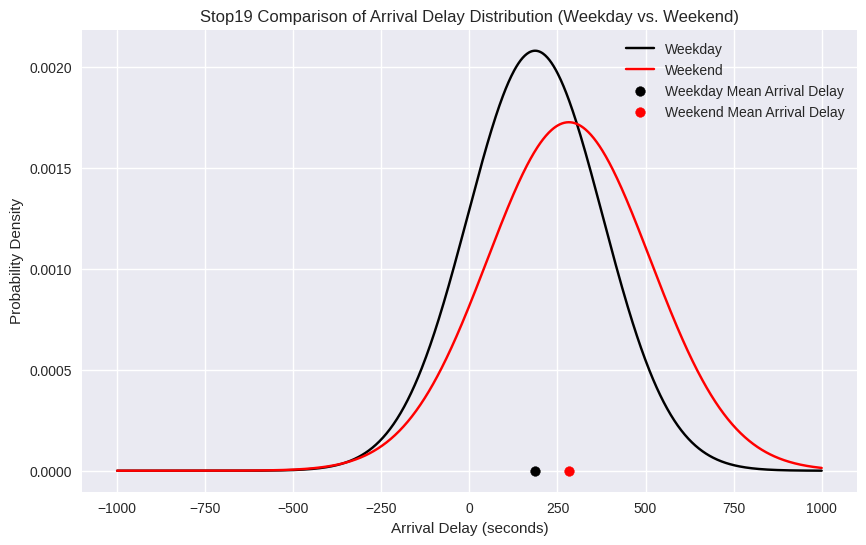

In [26]:
# Extract 'arrival_delay' data for both datasets
Stop19_arrival_delay_weekday = df_stop19_weekday['arrival_delay']
Stop19_arrival_delay_weekend = df_stop19_weekend['arrival_delay']

mean_stop19_weekday = Stop19_arrival_delay_weekday.mean()
std_dev_stop19__weekday = Stop19_arrival_delay_weekday.std()
mean_stop19_weekend = Stop19_arrival_delay_weekend.mean()
std_dev_stop19_weekend = Stop19_arrival_delay_weekend.std()

x = np.linspace(-1000, 1000, 1000)

pdf_stop19_weekday = norm.pdf(x, loc=mean_stop19_weekday, scale=std_dev_stop19__weekday)
pdf_stop19_weekend = norm.pdf(x, loc=mean_stop19_weekend, scale=std_dev_stop19_weekend)

plt.figure(figsize=(10, 6))

# Plot the PDFs for both datasets
plt.plot(x, pdf_stop19_weekday, label='Weekday', color='black')
plt.plot(x, pdf_stop19_weekend, label='Weekend', color='red')

plt.scatter([mean_stop19_weekday], [0], color=['black'], marker='o', label='Weekday Mean Arrival Delay')
plt.scatter([mean_stop19_weekend], [0], color=['red'], marker='o', label='Weekend Mean Arrival Delay')

plt.xlabel('Arrival Delay (seconds)')
plt.ylabel('Probability Density')
plt.title('Stop19 Comparison of Arrival Delay Distribution (Weekday vs. Weekend)')
plt.legend()
plt.grid(True)

plt.show()

# Model 1: Weekday Model
Using only data during weekdays

### Regression

#### Training and prediction & Evalustion & Vusualization

In [27]:
from sklearn.model_selection import cross_val_score

subset19_M1_RG = df_stop19_weekday[['traffic_condition', 'recurrent_delay']].copy()
subset19_M1_RG['traffic_condition'] = subset19_M1_RG['traffic_condition'].astype(int)
subset19_M1_RG['recurrent_delay'] = subset19_M1_RG['recurrent_delay'].astype(int)

df_stop19_weekday[['traffic_condition', 'recurrent_delay']] = subset19_M1_RG

x = df_stop19_weekday.drop(['arrival_delay', 'day_of_week', 'time_of_day' ], axis=1)
y = df_stop19_weekday['arrival_delay']

# Neural Network Model
Model_weekday_RG = LinearRegression()
# Try corss validation score first
cross_val_score(Model_weekday_RG, x, y, cv=5).mean()

<ipython-input-27-8696eafe6554>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stop19_weekday[['traffic_condition', 'recurrent_delay']] = subset19_M1_RG


0.9929752396437104

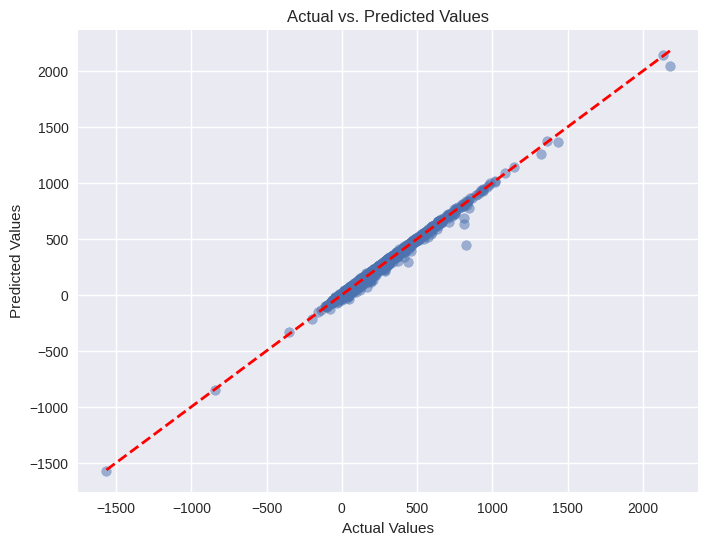

In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Fit the model to the training data
Model_weekday_RG.fit(x_train, y_train)

y_pred = Model_weekday_RG.predict(x_test)

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

In [29]:
mae_M1_RG = mean_absolute_error(y_test, y_pred)
mse_M1_RG = mean_squared_error(y_test, y_pred)
r2_M1_RG = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae_M1_RG}")
print(f"Mean Squared Error: {mse_M1_RG}")
print(f"R-squared: {r2_M1_RG}")

Mean Absolute Error: 8.43328745564089
Mean Squared Error: 216.71903619523854
R-squared: 0.9940520089950754


### Neural Network

In [67]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
filepath=""
%matplotlib inline

In [74]:
subset19_M1_NN = df_stop19_weekday[['traffic_condition', 'recurrent_delay']].copy()

subset19_M1_NN['traffic_condition'] = subset19_M1_NN['traffic_condition'].astype(int)
subset19_M1_NN['recurrent_delay'] = subset19_M1_NN['recurrent_delay'].astype(int)

df_stop19_weekday[['traffic_condition', 'recurrent_delay']] = subset19_M1_NN

x = df_stop19_weekday.drop(['arrival_delay', 'day_of_week', 'time_of_day' ], axis=1)
y = df_stop19_weekday['arrival_delay']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

<ipython-input-74-5ef965a73d5f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stop19_weekday[['traffic_condition', 'recurrent_delay']] = subset19_M1_NN


In [77]:
# network construction
def construct_network_model():
  model_weekday_NN = Sequential()
  model_weekday_NN.add(Dense(32, activation='linear', input_dim=10))
  model_weekday_NN.add(Dropout(rate=0.001))
  model_weekday_NN.add(Dense(64, activation='linear'))
  model_weekday_NN.add(Dense(1))
  return model_weekday_NN

model_weekday_NN = construct_network_model()
model_weekday_NN.compile(optimizer='adam', loss='mae', metrics=['mae']) # default 'optimizer'
model_weekday_NN.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 32)                352       
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_28 (Dense)            (None, 64)                2112      
                                                                 
 dense_29 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2529 (9.88 KB)
Trainable params: 2529 (9.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



Epoch 1: val_mae improved from inf to 9.86930, saving model to weights.best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_mae did not improve from 9.86930

Epoch 3: val_mae improved from 9.86930 to 8.26301, saving model to weights.best.h5

Epoch 4: val_mae did not improve from 8.26301

Epoch 5: val_mae improved from 8.26301 to 8.20034, saving model to weights.best.h5

Epoch 6: val_mae did not improve from 8.20034

Epoch 7: val_mae did not improve from 8.20034

Epoch 8: val_mae did not improve from 8.20034

Epoch 9: val_mae did not improve from 8.20034

Epoch 10: val_mae improved from 8.20034 to 8.16892, saving model to weights.best.h5

Epoch 11: val_mae did not improve from 8.16892

Epoch 12: val_mae did not improve from 8.16892

Epoch 13: val_mae did not improve from 8.16892

Epoch 14: val_mae improved from 8.16892 to 8.07401, saving model to weights.best.h5

Epoch 15: val_mae improved from 8.07401 to 8.03543, saving model to weights.best.h5

Epoch 16: val_mae did not improve from 8.03543

Epoch 17: val_mae did not improve from 8.03543

Epoch 18: val_mae did not improve from 8.03543

Epoch 

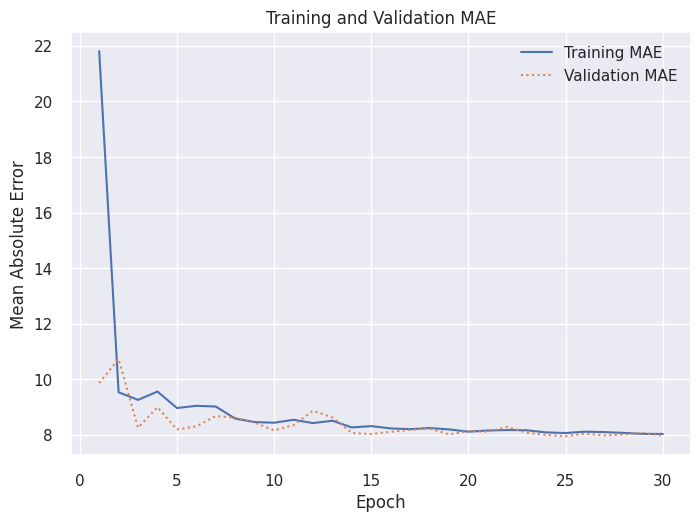

In [78]:
# model training -- choose to use callback function

early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3)
filepath = "weights.best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
hist = model_weekday_NN.fit(x_train, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[early_stop, reduce_lr,checkpoint],verbose=0)

# model evaluation and plot
sns.set()
err = hist.history['mae']
val_err = hist.history['val_mae']
epochs = range(1, len(err) + 1)

plt.plot(epochs, err, '-', label='Training MAE')
plt.plot(epochs, val_err, ':', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='upper right')
plt.plot()

y_pred = model_weekday_NN.predict(x_test)

mae_M1_NN = mean_absolute_error(y_test, y_pred)
mse_M1_NN = mean_squared_error(y_test, y_pred)
r2_M1_NN = r2_score(y_test, y_pred)

print('This is result of the trained model: ')
# Print the evaluation metrics.
print(f"Mean Absolute Error: {mae_M1_NN}")
print(f"Mean Squared Error: {mse_M1_NN}")
print(f"R-squared: {r2_M1_NN}")

# Load model and evaluation
if not filepath =="":
  model_weekday_NN = load_model(filepath)
  y_pred = model_weekday_NN.predict(x_test)
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  print('This is result of the model loaded from the local path: ')

  # Print the calculated metrics.
  print(f"Mean Absolute Error: {mae_M1_NN}")
  print(f"Mean Squared Error: {mse_M1_NN}")
  print(f"R-squared: {r2_M1_NN}")

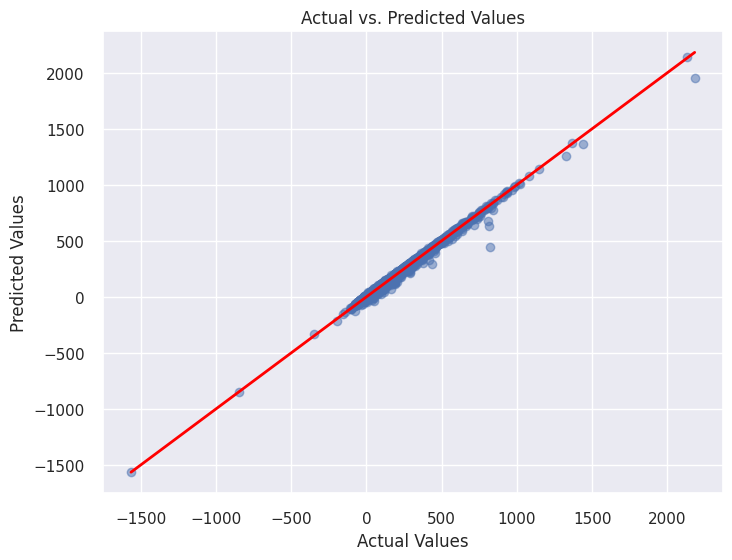

In [54]:
  # create a scatter plot to visualize the relationship
  plt.figure(figsize=(8, 6))
  plt.scatter(y_test, y_pred, alpha = 0.5)

  # add labels and title
  plt.xlabel("Actual Values")
  plt.ylabel("Predicted Values")
  plt.title("Actual vs. Predicted Values")

  # add a diagonal line for reference
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle = '-', color = 'red', lw=2)
  plt.show()

### Decision Tree

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

subset19_M1_DT = df_stop19_weekday[['traffic_condition', 'recurrent_delay']].copy()
subset19_M1_DT['traffic_condition'] = subset19_M1_DT['traffic_condition'].astype(int)
subset19_M1_DT['recurrent_delay'] = subset19_M1_DT['recurrent_delay'].astype(int)

df_stop19_weekday[['traffic_condition', 'recurrent_delay']] = subset19_M1_DT

x = df_stop19_weekday.drop(['arrival_delay', 'day_of_week', 'time_of_day'], axis=1)
y = df_stop19_weekday['arrival_delay']

# Decision Tree Model
Model_weekday_DT = DecisionTreeRegressor(random_state=42)  # You can adjust hyperparameters as needed

# Try cross-validation score
cross_val_score(Model_weekday_DT, x, y, cv=5, scoring='neg_mean_squared_error').mean()

<ipython-input-35-413d7a8dc480>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stop19_weekday[['traffic_condition', 'recurrent_delay']] = subset19_M1_DT


-2097.307553739609

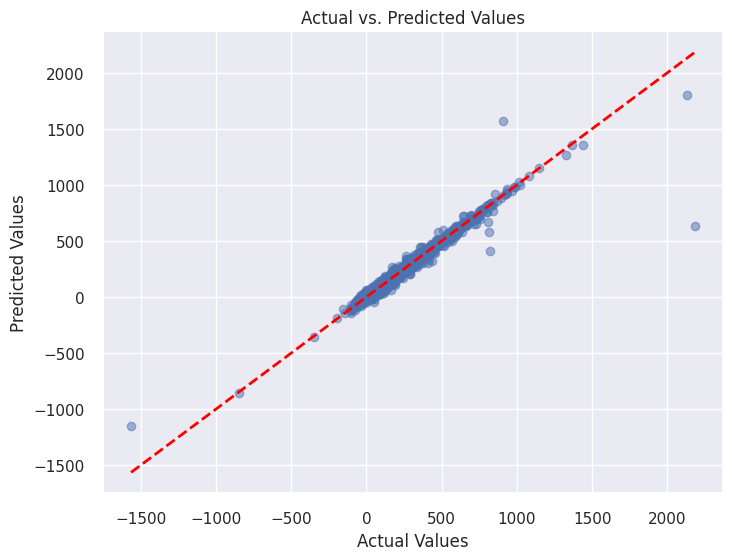

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Fit the model to the training data
Model_weekday_DT.fit(x_train, y_train)

y_pred = Model_weekday_DT.predict(x_test)

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

In [37]:
mae_M1_DT = mean_absolute_error(y_test, y_pred)
mse_M1_DT = mean_squared_error(y_test, y_pred)
r2_M1_DT = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae_M1_DT}")
print(f"Mean Squared Error: {mse_M1_DT}")
print(f"R-squared: {r2_M1_DT}")

Mean Absolute Error: 13.741123305358295
Mean Squared Error: 1426.3518398967076
R-squared: 0.9608528717065711


# Model 2: Weekend Model
Using only data during weekdays and specified particular variables

In [38]:
# Check the number of records
# Extract 'weekday' and 'weekend' from day_of_week to train
df_stop19_weekend = df_stop19[df_stop19['day_of_week'] == 'weekend']
print(df_stop19_weekend.shape)

(4702, 13)


### Regression

#### Training and prediction & Evalustion & Vusualization

In [39]:
from sklearn.model_selection import cross_val_score

subset19_M2_RG = df_stop19_weekend[['traffic_condition', 'recurrent_delay']].copy()

subset19_M2_RG['traffic_condition'] = subset19_M2_RG['traffic_condition'].astype(int)
subset19_M2_RG['recurrent_delay'] = subset19_M2_RG['recurrent_delay'].astype(int)

df_stop19_weekend[['traffic_condition', 'recurrent_delay']] = subset19_M2_RG

x = df_stop19_weekend.drop(['arrival_delay', 'day_of_week', 'time_of_day' ], axis=1)
y = df_stop19_weekend['arrival_delay']

# Neural Network Model
Model_weekend_RG = LinearRegression()
# Try corss validation score first
cross_val_score(Model_weekend_RG, x, y, cv=5).mean()

<ipython-input-39-bede318372d2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stop19_weekend[['traffic_condition', 'recurrent_delay']] = subset19_M2_RG


0.9976159988027801

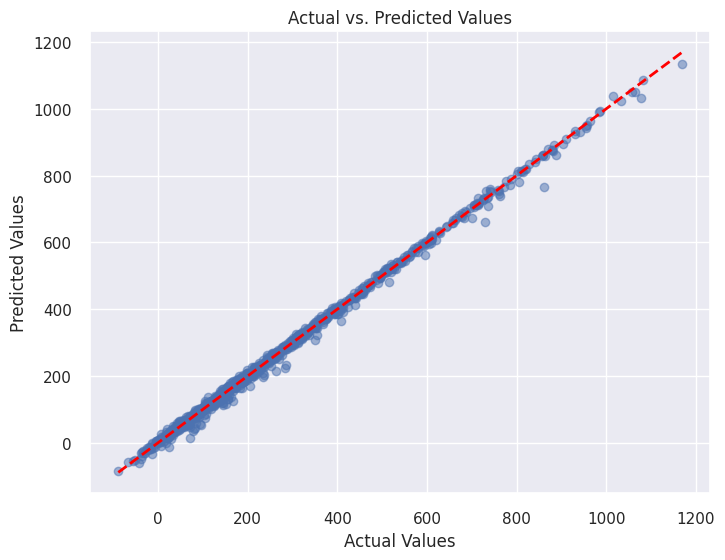

In [40]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Fit the model to the training data
Model_weekend_RG.fit(x_train, y_train)

y_pred = Model_weekend_RG.predict(x_test)

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

In [41]:
mae_M2_RG = mean_absolute_error(y_test, y_pred)
mse_M2_RG = mean_squared_error(y_test, y_pred)
r2_M2_RG = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae_M2_RG}")
print(f"Mean Squared Error: {mse_M2_RG}")
print(f"R-squared: {r2_M2_RG}")

Mean Absolute Error: 7.1733852815181205
Mean Squared Error: 120.46374148363594
R-squared: 0.9977210811223182


### Neural Network

In [42]:
from sklearn.model_selection import cross_val_score

subset19_M2_NN = df_stop19_weekend[['traffic_condition', 'recurrent_delay']].copy()

subset19_M2_NN['traffic_condition'] = subset19_M2_NN['traffic_condition'].astype(int)
subset19_M2_NN['recurrent_delay'] = subset19_M2_NN['recurrent_delay'].astype(int)

df_stop19_weekend[['traffic_condition', 'recurrent_delay']] = subset19_M2_NN

x = df_stop19_weekend.drop(['arrival_delay', 'day_of_week', 'time_of_day' ], axis=1)
y = df_stop19_weekend['arrival_delay']

# Neural Network Model
Model_weekend_RG = LinearRegression()
# Try corss validation score first
cross_val_score(Model_weekend_RG, x, y, cv=5).mean()

<ipython-input-42-3961e0a8e8d5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stop19_weekend[['traffic_condition', 'recurrent_delay']] = subset19_M2_NN


0.9976159988027801

In [43]:
# network construction
def construct_network_model():
  model_weekend_NN = Sequential()
  model_weekend_NN.add(Dense(32, activation='linear', input_dim=10))
  model_weekend_NN.add(Dropout(rate=0.001))
  model_weekend_NN.add(Dense(64, activation='linear'))
  model_weekend_NN.add(Dense(1))
  return model_weekend_NN

model_weekend_NN = construct_network_model()
model_weekend_NN.compile(optimizer='adam', loss='mae', metrics=['mae']) # default 'optimizer'
model_weekend_NN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                352       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2529 (9.88 KB)
Trainable params: 2529 (9.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



Epoch 1: val_mae improved from inf to 14.90554, saving model to weights.best.h5

Epoch 2: val_mae improved from 14.90554 to 12.15057, saving model to weights.best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_mae improved from 12.15057 to 9.16898, saving model to weights.best.h5

Epoch 4: val_mae improved from 9.16898 to 8.65364, saving model to weights.best.h5

Epoch 5: val_mae improved from 8.65364 to 8.43970, saving model to weights.best.h5

Epoch 6: val_mae improved from 8.43970 to 7.41796, saving model to weights.best.h5

Epoch 7: val_mae did not improve from 7.41796

Epoch 8: val_mae did not improve from 7.41796

Epoch 9: val_mae did not improve from 7.41796

Epoch 10: val_mae did not improve from 7.41796

Epoch 11: val_mae improved from 7.41796 to 7.27380, saving model to weights.best.h5

Epoch 12: val_mae did not improve from 7.27380

Epoch 13: val_mae did not improve from 7.27380

Epoch 14: val_mae did not improve from 7.27380

Epoch 15: val_mae improved from 7.27380 to 6.96324, saving model to weights.best.h5

Epoch 16: val_mae did not improve from 6.96324

Epoch 17: val_mae did not improve from 6.96324

Epoch 18: val_mae did not improve from 6.96324

Epoch 19: val_m

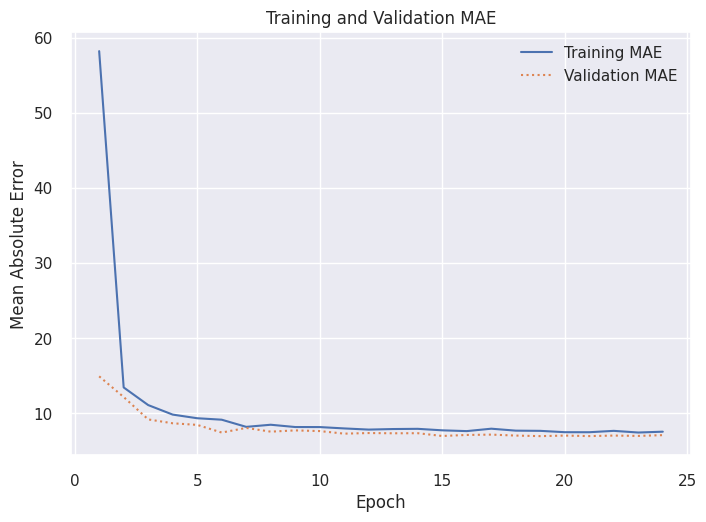

In [44]:
# model training -- choose to use callback function

early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3)
filepath = "weights.best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
hist = model_weekend_NN.fit(x_train, y_train, validation_split=0.2, epochs=200, batch_size=64, callbacks=[early_stop, reduce_lr,checkpoint],verbose=0)

# model evaluation and plot
sns.set()
err = hist.history['mae']
val_err = hist.history['val_mae']
epochs = range(1, len(err) + 1)

plt.plot(epochs, err, '-', label='Training MAE')
plt.plot(epochs, val_err, ':', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='upper right')
plt.plot()

y_pred = model_weekend_NN.predict(x_test)

mae_M2_NN = mean_absolute_error(y_test, y_pred)
mse_M2_NN = mean_squared_error(y_test, y_pred)
r2_M2_NN = r2_score(y_test, y_pred)

print('This is result of the trained model: ')
# Print the evaluation metrics.
print(f"Mean Absolute Error: {mae_M2_NN}")
print(f"Mean Squared Error: {mse_M2_NN}")
print(f"R-squared: {r2_M2_NN}")

# Load model and evaluation
if not filepath =="":
  model_weekend_NN = load_model(filepath)
  y_pred = model_weekend_NN.predict(x_test)
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  print('This is result of the model loaded from the local path: ')

  # Print the calculated metrics.
  print(f"Mean Absolute Error: {mae_M2_NN}")
  print(f"Mean Squared Error: {mse_M2_NN}")
  print(f"R-squared: {r2_M2_NN}")

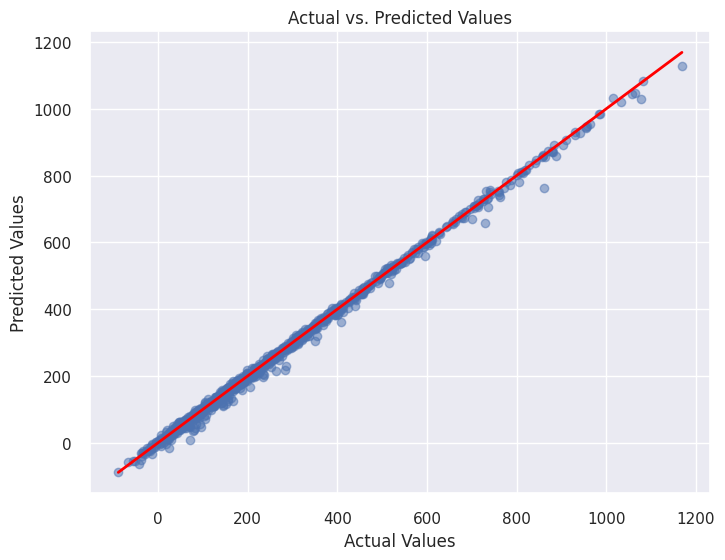

In [45]:
# create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha = 0.5)

# add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# add a diagonal line for reference
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle = '-', color = 'red', lw=2)
plt.show()

### Decision Tree

In [48]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

subset19_M2_DT = df_stop19_weekend[['traffic_condition', 'recurrent_delay']].copy()
subset19_M2_DT['traffic_condition'] = subset19_M2_DT['traffic_condition'].astype(int)
subset19_M2_DT['recurrent_delay'] = subset19_M2_DT['recurrent_delay'].astype(int)

df_stop19_weekend[['traffic_condition', 'recurrent_delay']] = subset19_M2_DT

x = df_stop19_weekend.drop(['arrival_delay', 'day_of_week', 'time_of_day'], axis=1)
y = df_stop19_weekend['arrival_delay']

# Decision Tree Model
Model_weekend_DT = DecisionTreeRegressor(random_state=42)  # You can adjust hyperparameters as needed

# Try cross-validation score
cross_val_score(Model_weekend_DT, x, y, cv=5, scoring='neg_mean_squared_error').mean()

<ipython-input-48-8454e39c5e29>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stop19_weekend[['traffic_condition', 'recurrent_delay']] = subset19_M2_DT


-317.93971216677596

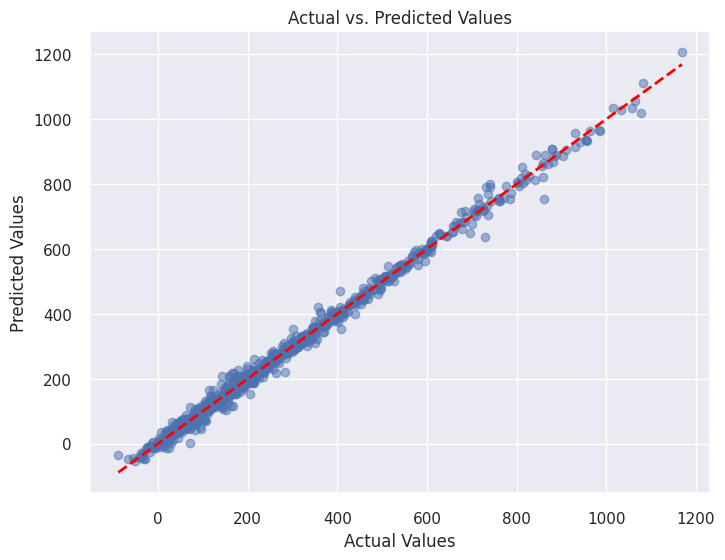

In [49]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Fit the model to the training data
Model_weekend_DT.fit(x_train, y_train)

y_pred = Model_weekend_DT.predict(x_test)

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

In [50]:
mae_M1_DT = mean_absolute_error(y_test, y_pred)
mse_M1_DT = mean_squared_error(y_test, y_pred)
r2_M1_DT = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae_M1_DT}")
print(f"Mean Squared Error: {mse_M1_DT}")
print(f"R-squared: {r2_M1_DT}")

Mean Absolute Error: 11.313496280552604
Mean Squared Error: 274.62061636556854
R-squared: 0.9948047595141221
